In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from scipy import stats

# clustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

#Outlier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

#Feature Selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE


#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

#Timing classification
import time

In [ ]:
# upload UCI_Credit_Card.csv to files
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Preprocessing

In [ ]:
# check if any missing information is present in a csv file.

#Number of rows before
print(f"Number of Rows before cleaning: {data.shape[0]}")

#Clean data
data = data.dropna()

#Check number of rows after:

print(f"Number of Rows after cleaning: {data.shape[0]}")

# should we also remove 0 values for certain attributes?
# Looking at the scatter plots, it looks like some values of 0 make analysis
# harder.

Number of Rows before cleaning: 30000
Number of Rows after cleaning: 30000


There are no values in the dataset that are missing in the form of NA

In [ ]:
# Drop duplicates
#Number of rows before
print(f"Number of rows before removing duplicates: {data.shape[0]}")

duplicate_count = data.duplicated().sum()

print(f"Number of duplicates: {duplicate_count}")

if(duplicate_count == 0):
  print("no duplicates")

else:
  data = data.drop_duplicates()
  print(f"Number of rows after removing duplicates: {data.shape[0]}")

Number of rows before removing duplicates: 30000
Number of duplicates: 0
no duplicates


We have dropped data rows that do not make sense (Example: Marriage that is listed as 1 = married, 2 = single, 3 = others, but some rows had 0. We were unsure what this meant so the rows that had it were droppped.)

In [ ]:
#Drop odd values in categorical values
print(f"Number of rows before removing odd rows: {data.shape[0]}")

data = data[data['MARRIAGE'].isin([1,2,3])]
data = data[data['EDUCATION'].isin([1,2,3,4,5,6])]
data = data[data['SEX'].isin([1,2])]

pay_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for pay in pay_list:
  # -2 is assumed to be no credit to pay
  # -1 is credit paid fully
  # 0 is assumed to be payment made on time (minimum satement)
  data = data[data[pay].isin(range(-2,10))]


print(f"Number of rows after removing odd rows: {data.shape[0]}")

Number of rows before removing odd rows: 30000
Number of rows after removing odd rows: 29932


In [ ]:
# one-hot encoding of categorical features
cat_cols = ['MARRIAGE']
data[cat_cols] = data[cat_cols].astype('category')
data = pd.get_dummies(data, columns=cat_cols, dtype=int)

In [ ]:
# See new column names
print(data.columns.tolist())

# Compare before/after shape
print("Shape after encoding:", data.shape)

data.head()

data.to_csv('preprocessed_data.csv')

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']
Shape after encoding: (29932, 27)


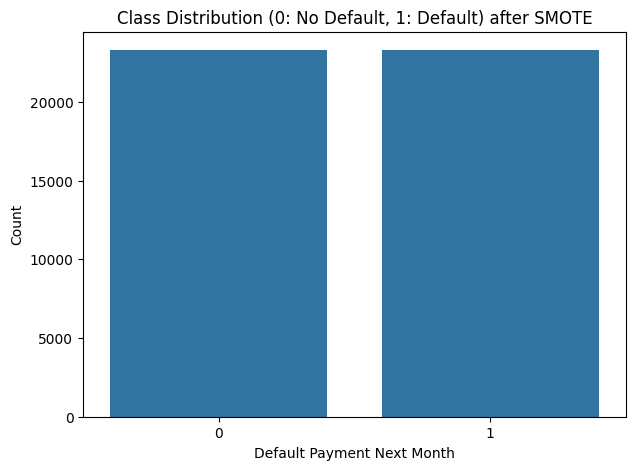

default.payment.next.month
1    23301
0    23301
Name: count, dtype: int64


,ID,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default.payment.next.month
0,1,20000.0,2,2,24,2,2,-1,-1,-2,...,0.0,689.0,0.0,0.0,0.0,0.0,1,0,0,1
1,2,120000.0,2,2,26,-1,2,0,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0,1,0,1
2,3,90000.0,2,2,34,0,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,1,0,0
3,4,50000.0,2,2,37,0,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1,0,0,0
4,5,50000.0,1,2,57,-1,0,-1,0,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,0,0,0


In [ ]:
# Data augmentation generating synthetic samples
# use SMOTE to solve class imbalance problem
x = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']
smote=SMOTE(sampling_strategy='minority', random_state=42)
x,y=smote.fit_resample(x,y)
plt.figure(figsize=(7,5))
sns.countplot(x=y)
plt.title('Class Distribution (0: No Default, 1: Default) after SMOTE')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Count')
plt.show()
print(y.value_counts())
data = pd.concat([x, y], axis=1)
data.head()

In [ ]:
# Normalization/Standardization of data
scaler = StandardScaler()
num_cols = ['LIMIT_BAL','AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
data[num_cols].describe().T[['mean', 'std']]

,mean,std
LIMIT_BAL,153471.321447,125705.256440
AGE,35.384983,8.800554
BILL_AMT1,50049.928509,73389.635716
BILL_AMT2,48384.255655,71233.040488
BILL_AMT3,46423.306642,69205.366988
BILL_AMT4,42894.225139,64402.148520
BILL_AMT5,40094.228248,61123.471881
BILL_AMT6,38768.348757,59773.451024
PAY_AMT1,4748.573797,14119.029807
PAY_AMT2,4922.841142,19492.488034


In [ ]:
data[num_cols] = scaler.fit_transform(data[num_cols])
data[num_cols].describe().T[['mean', 'std']]

,mean,std
LIMIT_BAL,-7.318581e-17,1.000011
AGE,4.391149e-17,1.000011
BILL_AMT1,6.952652e-17,1.000011
BILL_AMT2,9.880084e-17,1.000011
BILL_AMT3,1.951622e-17,1.000011
BILL_AMT4,-2.515762e-17,1.000011
BILL_AMT5,9.026250e-17,1.000011
BILL_AMT6,2.317551e-17,1.000011
PAY_AMT1,1.707669e-17,1.000011
PAY_AMT2,-2.439527e-18,1.000011


In [ ]:
# save preprocessed data to csv file
data.to_csv('preprocessed_data.csv', index=False)

### Read Preprocseed Data ###

In [2]:
data = pd.read_csv('preprocessed_data.csv')

# Clustering

C:\Users\Preston\AppData\Local\Temp\ipykernel_3484\4250305936.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Preston\AppData\Local\Temp\ipykernel_3484\4250305936.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


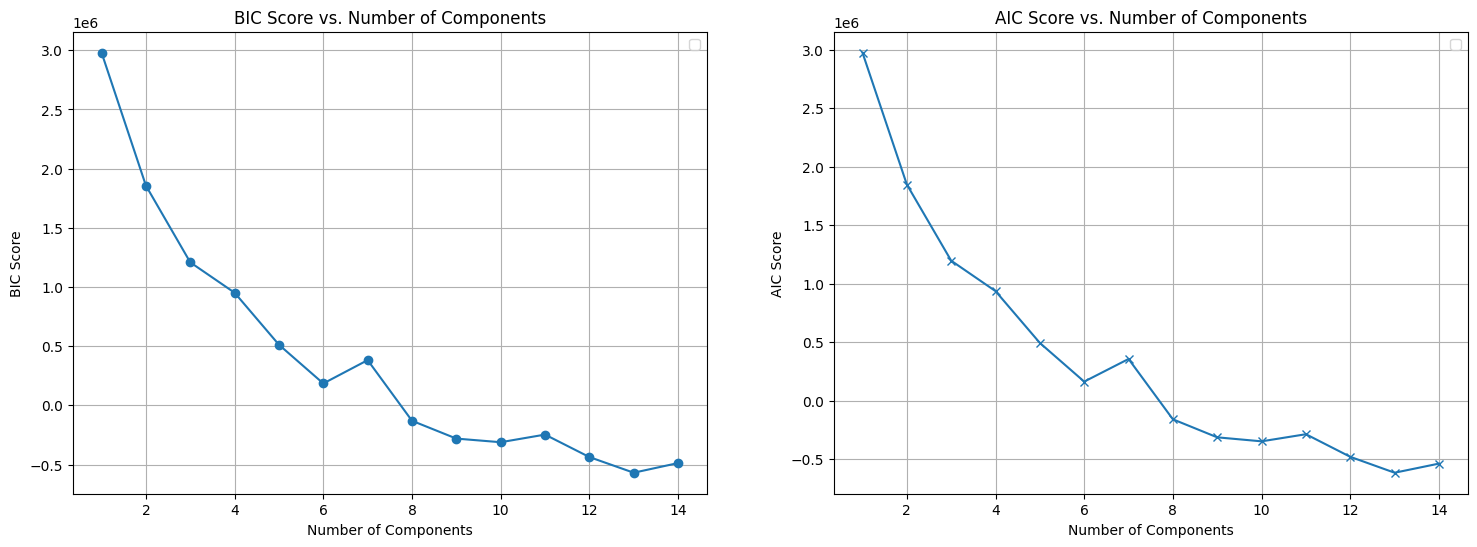

In [ ]:
# Find optimal number of components using BIC and AIC
n_components = np.arange(1, 15)
bic_scores = []
aic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data)
    bic_scores.append(gmm.bic(data))
    aic_scores.append(gmm.aic(data))

# Plot the BIC and AIC scores
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(n_components, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components, aic_scores, marker='x')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# set up components needed for clustering
X_clustering = data.drop(['ID', 'default.payment.next.month'], axis=1)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_clustering)

tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(X_clustering)

def visualize_cluster(components, cluster_labels, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Cluster')
    plt.show()

Clustering Method 1: Probabilistic Clustering - GMM

Clustering Performance Metrics:
Silhouette Score: 0.1206
Calinski-Harabasz Index: 2540.4517
Davies-Bouldin Index: 3.6517


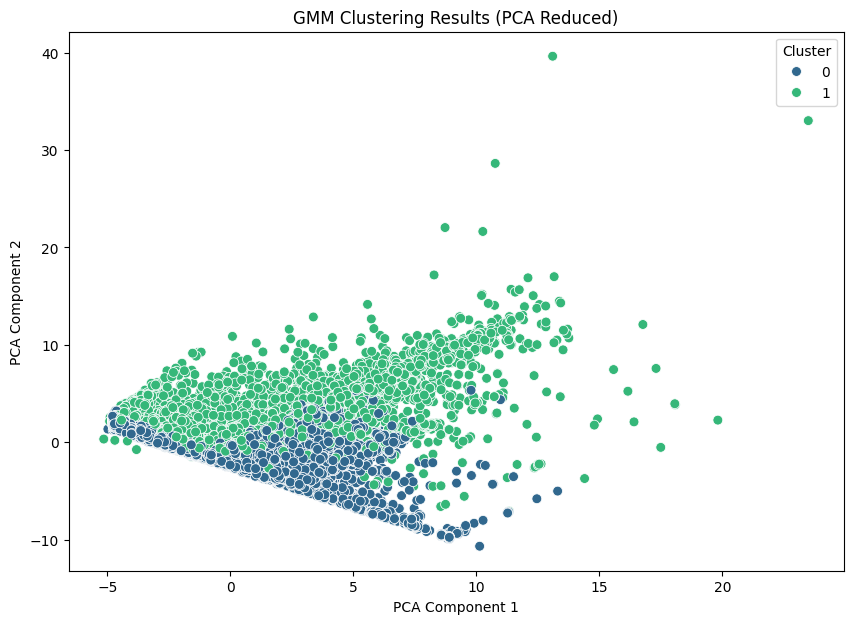


Cluster Means:
         LIMIT_BAL       SEX  EDUCATION       AGE     PAY_0     PAY_2  \
cluster                                                                 
0        -0.226216  1.497963   1.776637 -0.020616  0.290110  0.136621   
1         0.479178  1.524724   1.739110  0.043669 -0.075209 -0.168351   

            PAY_3     PAY_4     PAY_5     PAY_6  ...  BILL_AMT6  PAY_AMT1  \
cluster                                          ...                        
0        0.090280  0.031178 -0.029630 -0.071453  ...  -0.173408 -0.191562   
1       -0.223352 -0.278689 -0.311542 -0.330880  ...   0.367318  0.405772   

         PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  MARRIAGE_1  \
cluster                                                                 
0       -0.151181 -0.178959 -0.188741 -0.184632 -0.183185    0.362068   
1        0.320236  0.379078  0.399798  0.391093  0.388029    0.408899   

         MARRIAGE_2  MARRIAGE_3  
cluster                          
0          0.419402  

In [ ]:
# 1. Setup Data (Drop Target and ID for clustering)
# Ensure 'data' is your scaled/preprocessed dataframe
X_clustering = data.drop(['ID', 'default.payment.next.month'], axis=1)

# 2. Fit GMM
optimal_components = 2  # You can adjust this based on your BIC/AIC plots
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
cluster_labels = gmm.fit_predict(X_clustering)

# 3. Assign Labels back to a copy of data for analysis
df_clusters = data.copy()
df_clusters['cluster'] = cluster_labels

# 4. Evaluate Performance
print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_score(X_clustering, cluster_labels):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_clustering, cluster_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_clustering, cluster_labels):.4f}")

# 5. Visualize using PCA (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_clustering)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title('GMM Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Cluster Means Summary (Fixing your previous error)
# Group by the new 'cluster' column we created in df_clusters
cluster_summary = df_clusters.groupby('cluster')[X_clustering.columns].mean()
print("\nCluster Means:")
print(cluster_summary)

Clustering Method 2: Hierarchical Clustering

best number of clusters:  2
best distance function:  euclidean
silhouette score:  0.9481251377801815


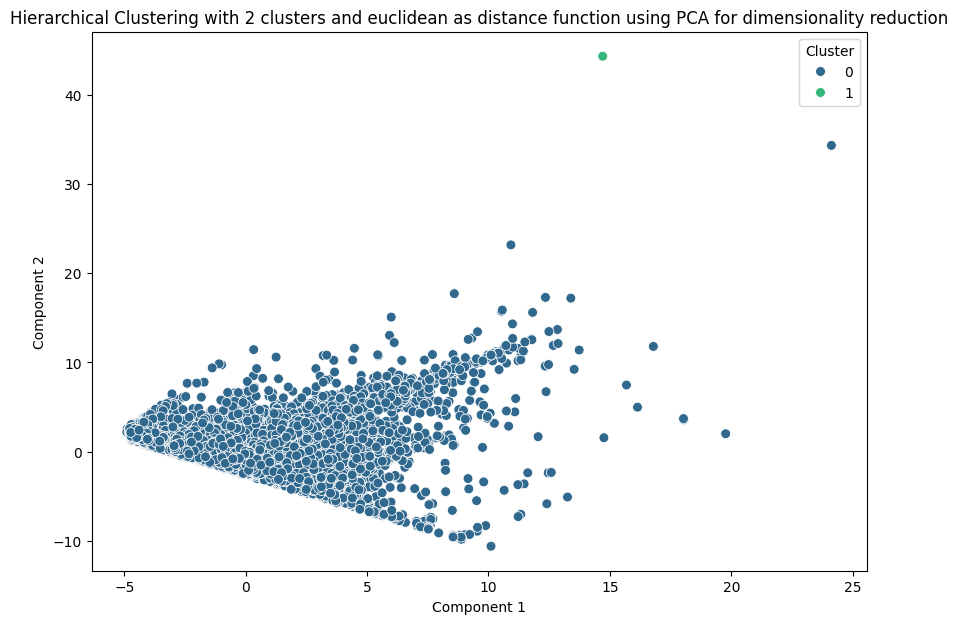

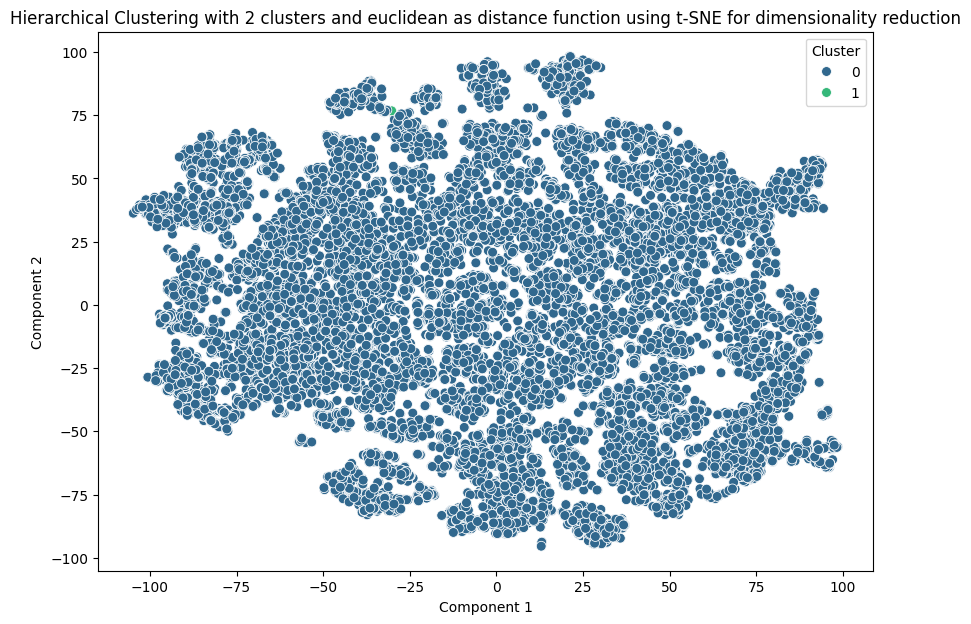

In [ ]:
# for this clustering algorithm, the data is too large and must be reduced
n_clusters = np.arange(2, 11)
metrics = {'euclidean', 'manhattan', 'cosine'}
# linkages = {'ward', 'complete', 'average', 'single'}
best_silhouette = -1.0
best_labels = None
best_n = 2
# best_link = None
best_metric = None

# find best model using small sample
data_sub = pd.DataFrame(data).sample(20000, random_state=42) # Reduce to 20k samples
X_sub = data_sub.drop(['default.payment.next.month', 'ID'], axis=1)
y_sub = data_sub['default.payment.next.month']

for n in n_clusters:
    for m in metrics:
        clustering = AgglomerativeClustering(n_clusters=n, metric=m, linkage='complete')
        labels = clustering.fit_predict(X_sub)
        temp_silhouette_score = silhouette_score(X_sub, labels)
        if (temp_silhouette_score > best_silhouette):
            best_silhouette = temp_silhouette_score
            best_labels = labels
            best_n = n
            # best_link = l
            best_metric = m

print('best number of clusters: ', best_n)
print('best distance function: ', best_metric)
print('silhouette score: ', best_silhouette)

chart_X_sub = PCA(2).fit_transform(X_sub)

title = f"Hierarchical Clustering with {best_n} clusters and {best_metric} as distance function using PCA for dimensionality reduction"
visualize_cluster(chart_X_sub, best_labels, title)

# try with t-SNE
tsne_X_sub = TSNE(2).fit_transform(X_sub)
title_tsne = f"Hierarchical Clustering with {best_n} clusters and {best_metric} as distance function using t-SNE for dimensionality reduction"
visualize_cluster(tsne_X_sub, best_labels, title_tsne)

Clustering Method 3: K-Means

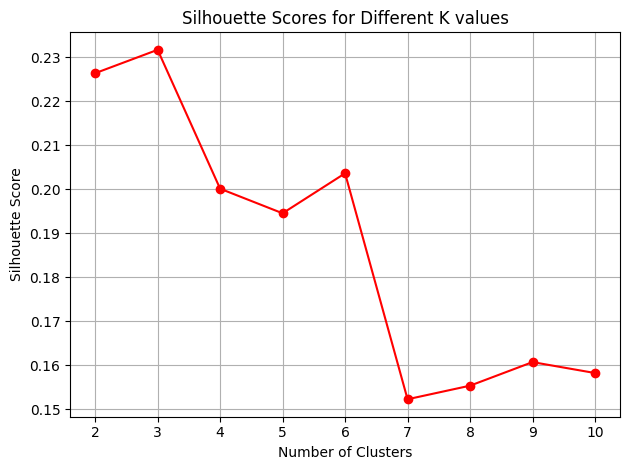

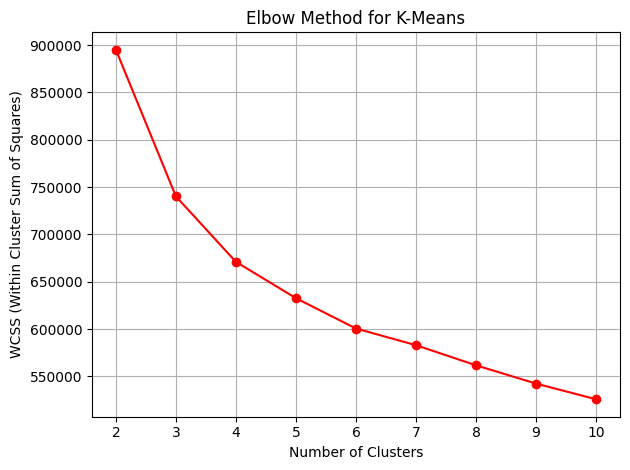

Cluster distribution:
Cluster
0    26285
1     5268
2    15049
Name: count, dtype: int64
Clustering Performance Metrics:
Silhouette Score: 0.2317
Calinski-Harabasz Index: 11297.9031
Davies-Bouldin Index: 1.4369


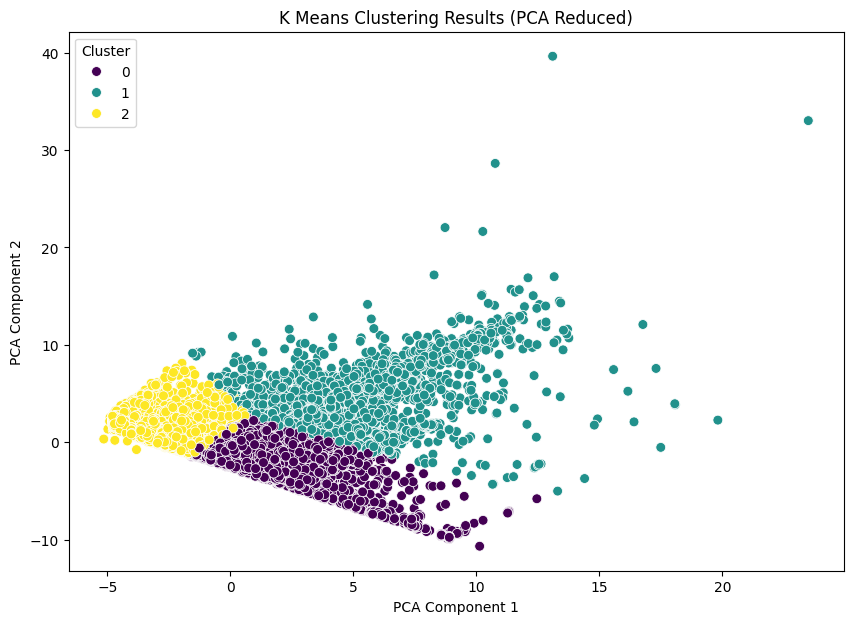

In [ ]:
wcss = []
silhouette_scores = []
k_range = range(2, 11)
X_scaled = data.drop(['ID','default.payment.next.month'], axis=1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores Method + Elbow Method

plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K values')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.plot(range(2, 11), wcss, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for K-Means')
plt.grid(True)

plt.tight_layout()
plt.show()

#Use Optimal k based on the results from the earlier k findings
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)
# Add cluster labels to original dataframe
df_with_clusters = data.copy()
df_with_clusters['Cluster'] = kmeans_clusters

print("Cluster distribution:")
print(df_with_clusters['Cluster'].value_counts().sort_index())

print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_clusters):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, kmeans_clusters):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_clusters):.4f}")

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=kmeans_clusters, palette='viridis', s=50)
plt.title('K Means Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Outlier Detection

In [ ]:
def visualize_outliers(components, y_pred_outliers, title):
    plt.figure(figsize=(10, 7))
    # Plot inliers
    plt.scatter(components[y_pred_outliers == 1, 0], components[y_pred_outliers == 1, 1],
                c='blue', label='Inliers', s=50, alpha=0.6)
    # Plot outliers
    plt.scatter(components[y_pred_outliers == -1, 0], components[y_pred_outliers == -1, 1],
                c='red', label='Outliers', s=50, marker='x')

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

In [ ]:
#Estimate Contamination Level
z_scores = np.abs(stats.zscore(data))
estimated_contamination = np.mean(z_scores > 3)
print(f"Estimated Contamination Level: {estimated_contamination:.4f}")

Estimated Contamination Level: 0.0103


Outlier Detection Method 1: Local Outlier Factor (LOF)

Number of outliers detected: 467
Number of inliers: 46135


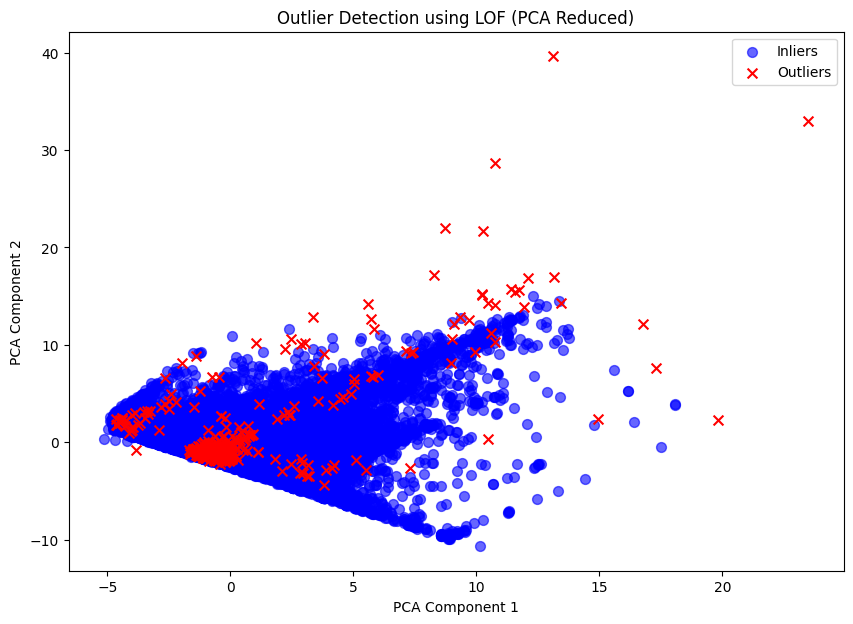

In [ ]:

# 1. Create a COPY for outlier analysis (Keeps 'data' pure)
df_outliers = data.copy()

# 2. Fit LOF
# We use X_clustering again since it only has the features we want
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
y_pred_outliers = lof.fit_predict(X_clustering) # Returns -1 for outliers, 1 for inliers

# 3. Store results in the COPY
df_outliers['outlier_lof'] = y_pred_outliers

# Identify outlier/inlier sets from the copy
outliers = df_outliers[df_outliers['outlier_lof'] == -1]
inliers = df_outliers[df_outliers['outlier_lof'] == 1]

print(f"Number of outliers detected: {len(outliers)}")
print(f"Number of inliers: {len(inliers)}")

# 4. Visualize Outliers using PCA (Re-using pca_components from above)
plt.figure(figsize=(10, 7))
# Plot inliers
plt.scatter(pca_components[y_pred_outliers == 1, 0], pca_components[y_pred_outliers == 1, 1],
            c='blue', label='Inliers', s=50, alpha=0.6)
# Plot outliers
plt.scatter(pca_components[y_pred_outliers == -1, 0], pca_components[y_pred_outliers == -1, 1],
            c='red', label='Outliers', s=50, marker='x')

plt.title('Outlier Detection using LOF (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Outlier Detection Method 2: Isolation Forset

In [ ]:
# I read https://www.geeksforgeeks.org/machine-learning/anomaly-detection-using-isolation-forest/ for help
X = data.drop(['default.payment.next.month', 'ID'], axis=1)
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
contaminations = {0.01, 0.05, 0.1, 0.125, 0.15, 0.2}

chart_X_test = PCA(2).fit_transform(X_test)
tsne_X_test = TSNE(2).fit_transform(X_test)

for contamination in contaminations:
    clf = IsolationForest(contamination=contamination)
    clf.fit(X_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # uncomment to see what each algorithm looks like
    # title = f"Isolation Forest with contamination level: {contamination} using PCA"
    # visualize_cluster(chart_X_test, y_pred_test, title)
    # title_tsne = f"Isolation Forest with contamination level: {contamination} using t-SNE"
    # visualize_cluster(tsne_X_test, y_pred_test, title_tsne)

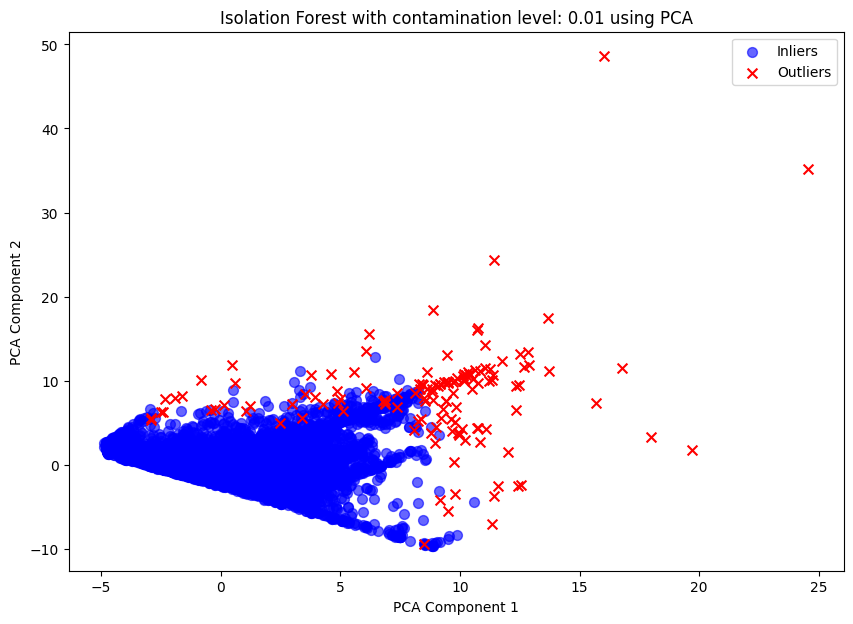

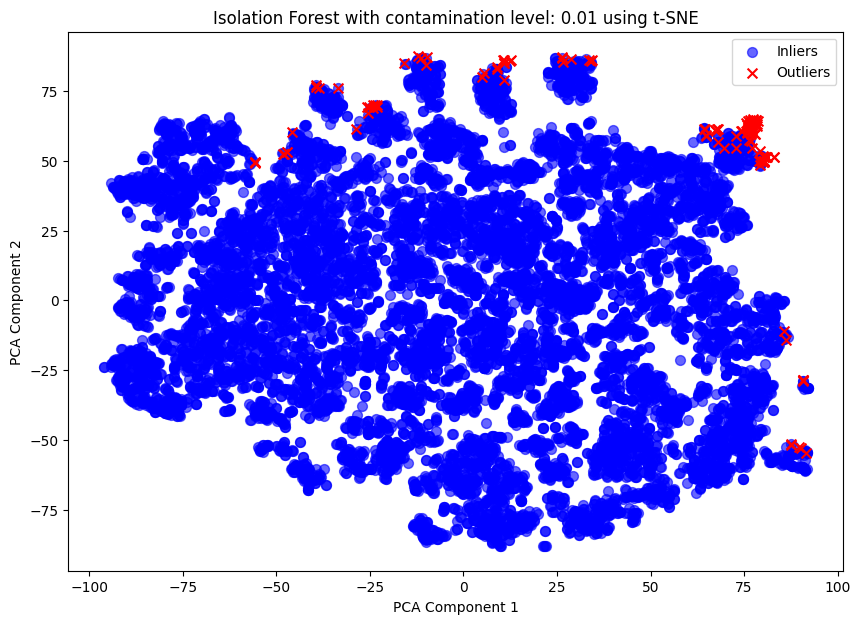

In [ ]:
# 0.01 looked the best
contamination = 0.01
clf = IsolationForest(contamination=contamination)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

title = f"Isolation Forest with contamination level: {contamination} using PCA"
X_test_pca = PCA(2).fit_transform(X_test)
visualize_outliers(X_test_pca, y_pred_test, title)

title_tsne = f"Isolation Forest with contamination level: {contamination} using t-SNE"
X_test_tsne = TSNE(2).fit_transform(X_test)
visualize_outliers(X_test_tsne, y_pred_test, title_tsne)

Outlier Detection Method 3: Elliptic Envolope


--- Testing contamination = 0.01 ---
Number of outliers: 467
Number of inliers: 46135
Outlier percentage: 1.00%

--- Testing contamination = 0.02 ---
Number of outliers: 933
Number of inliers: 45669
Outlier percentage: 2.00%

--- Testing contamination = 0.03 ---
Number of outliers: 1399
Number of inliers: 45203
Outlier percentage: 3.00%

--- Testing contamination = 0.04 ---
Number of outliers: 1865
Number of inliers: 44737
Outlier percentage: 4.00%

--- Testing contamination = 0.05 ---
Number of outliers: 2331
Number of inliers: 44271
Outlier percentage: 5.00%

--- Testing contamination = 0.06 ---
Number of outliers: 2797
Number of inliers: 43805
Outlier percentage: 6.00%

--- Testing contamination = 0.07 ---
Number of outliers: 3263
Number of inliers: 43339
Outlier percentage: 7.00%

--- Testing contamination = 0.08 ---
Number of outliers: 3729
Number of inliers: 42873
Outlier percentage: 8.00%

--- Testing contamination = 0.09 ---
Number of outliers: 4195
Number of inliers: 42407
Ou

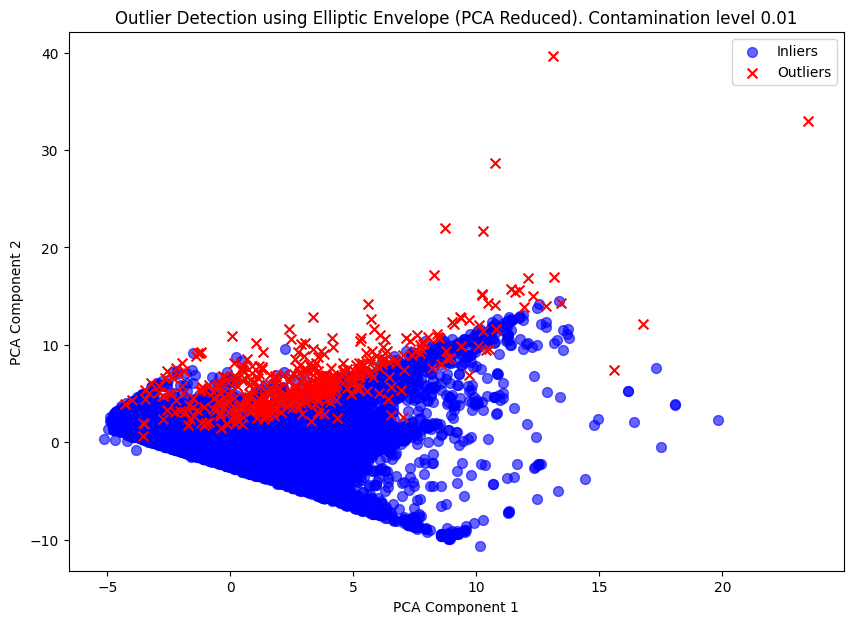

In [ ]:
data_outliers = data.copy()
X_elliptic = data_outliers.drop(['ID', 'default.payment.next.month'], axis=1)
y_elliptic = data_outliers['default.payment.next.month']

outlier_results = {}

contamination_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

for contamination in contamination_levels:
    print(f"\n--- Testing contamination = {contamination} ---")

    # Initialize Elliptic Envelope
    ee = EllipticEnvelope(contamination=contamination, random_state=42)

    # Fit and predict outliers (-1 for outliers, 1 for inliers)
    outlier_labels = ee.fit_predict(X_elliptic)

    data_outliers['outlier_ee'] = outlier_labels
    outliers_ee = data_outliers[data_outliers['outlier_ee'] == -1]
    inliers_ee = data_outliers[data_outliers['outlier_ee'] == 1]

    print(f'Number of outliers: {len(outliers_ee)}' )
    print(f'Number of inliers: {len(inliers_ee)}')
    print(f"Outlier percentage: {(len(outliers_ee)/len(data_outliers))*100:.2f}%")



    data_outliers = data_outliers.drop('outlier_ee', axis=1)

# Display best looking graph
# Initialize Elliptic Envelope
ee = EllipticEnvelope(contamination=0.01, random_state=42)

# Fit and predict outliers (-1 for outliers, 1 for inliers)
outlier_labels = ee.fit_predict(X_elliptic)

data_outliers['outlier_ee'] = outlier_labels
outliers_ee = data_outliers[data_outliers['outlier_ee'] == -1]
inliers_ee = data_outliers[data_outliers['outlier_ee'] == 1]

plt.figure(figsize=(10,7))
plt.scatter(pca_components[outlier_labels == 1, 0], pca_components[outlier_labels == 1, 1],
            c='blue', label='Inliers', s=50, alpha=0.6)
plt.scatter(pca_components[outlier_labels == -1, 0], pca_components[outlier_labels == -1, 1],
            c='red', label='Outliers', s=50,marker='x')
plt.title(f'Outlier Detection using Elliptic Envelope (PCA Reduced). Contamination level {0.01}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# Feature Selection

Feature Selection Method 1: Lasso Regression

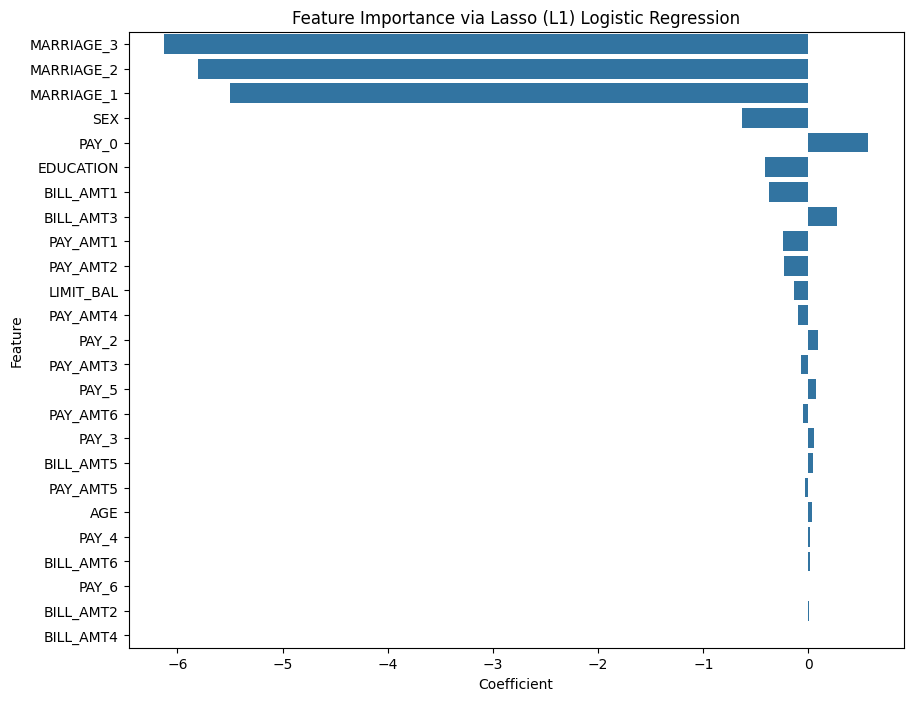

Selected Features (24): ['MARRIAGE_3', 'MARRIAGE_2', 'MARRIAGE_1', 'SEX', 'PAY_0', 'EDUCATION', 'BILL_AMT1', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'LIMIT_BAL', 'PAY_AMT4', 'PAY_2', 'PAY_AMT3', 'PAY_5', 'PAY_AMT6', 'PAY_3', 'BILL_AMT5', 'PAY_AMT5', 'AGE', 'PAY_4', 'BILL_AMT6', 'PAY_6', 'BILL_AMT2']

Feature Coefficients:
| Feature    |   Coefficient |
|:-----------|--------------:|
| MARRIAGE_3 |   -6.12791    |
| MARRIAGE_2 |   -5.80011    |
| MARRIAGE_1 |   -5.49939    |
| SEX        |   -0.635672   |
| PAY_0      |    0.569757   |
| EDUCATION  |   -0.411571   |
| BILL_AMT1  |   -0.376536   |
| BILL_AMT3  |    0.271426   |
| PAY_AMT1   |   -0.240319   |
| PAY_AMT2   |   -0.231193   |
| LIMIT_BAL  |   -0.138508   |
| PAY_AMT4   |   -0.0954581  |
| PAY_2      |    0.0943853  |
| PAY_AMT3   |   -0.0722606  |
| PAY_5      |    0.0696008  |
| PAY_AMT6   |   -0.0546419  |
| PAY_3      |    0.0505683  |
| BILL_AMT5  |    0.0404385  |
| PAY_AMT5   |   -0.0342544  |
| AGE        |    0.0324914 

In [20]:
# 1. Prepare Train/Test Data
X = data.drop(['ID', 'default.payment.next.month', 'outlier_lof', 'cluster'], axis=1, errors='ignore')
y = data['default.payment.next.month']

# 2. Apply Lasso (L1 Penalty)
# solver='liblinear' is required for L1 penalty
lasso_sel = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso_sel.fit(X, y)

# 3. Visualize Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_sel.coef_[0]
})
# Sort by absolute value of coefficient
feature_importance['Abs_Coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coef', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance via Lasso (L1) Logistic Regression')
plt.show()

# 4. Select Features
# Keep features where coefficient is not 0
selected_feats = feature_importance[feature_importance['Abs_Coef'] > 0]['Feature'].tolist()
print(f"Selected Features ({len(selected_feats)}): {selected_feats}")

# Update X to use only selected features for classification
X_selected_Lasso = X[selected_feats]

# Printing Coefficients
print("\nFeature Coefficients:")
print(feature_importance[['Feature', 'Coefficient']].to_markdown(index=False))

Feature Selection Method 2: Mutual information

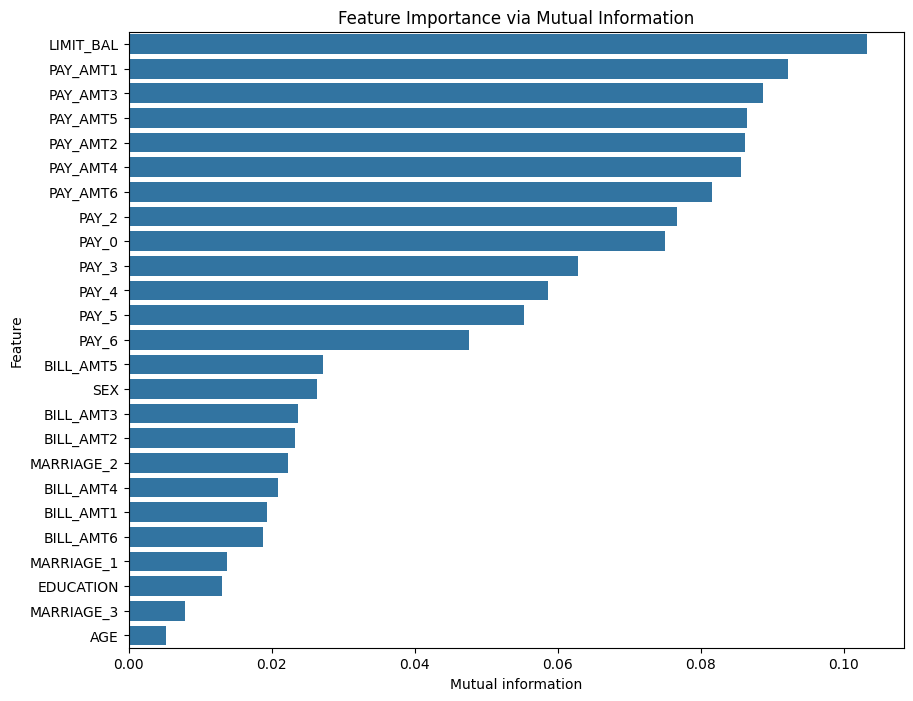

In [28]:
# X is feature matrix, y is target
X = data.drop(['default.payment.next.month', 'ID'], axis=1)
y = data['default.payment.next.month']

mi = mutual_info_classif(X, y, random_state=42)

# Convert MI scores into a readable format
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

feature_importance = pd.DataFrame({
    'Feature': mi_scores.index,
    'Mutual information': mi_scores
})

plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual information', y='Feature', data=feature_importance)
plt.title('Feature Importance via Mutual Information')
plt.show()

# Keep features where mutual informatoin is greater than 0.02
selected_feats = feature_importance[feature_importance['Mutual information'] > 0.02]['Feature'].tolist()

# Update X to use only selected features for classification
X_selected_mi = X[selected_feats]

Feature Selection Method 3: RFE

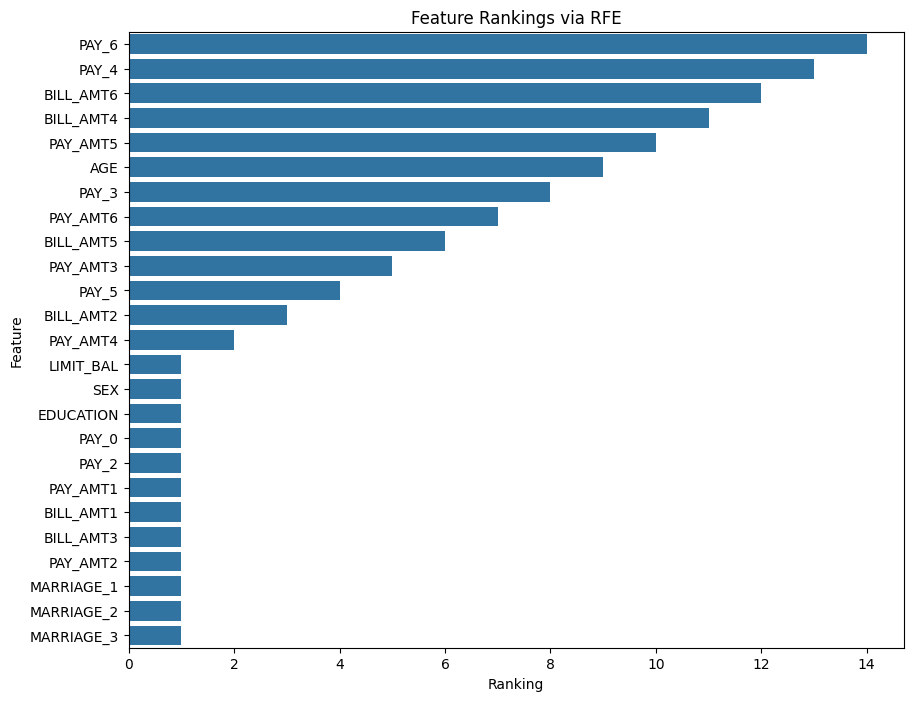

Selected Features (12): ['LIMIT_BAL', 'SEX', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_AMT1', 'BILL_AMT1', 'BILL_AMT3', 'PAY_AMT2', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']


In [ ]:

X_RFE = data.drop(['ID', 'default.payment.next.month'], axis=1)
y_RFE = data['default.payment.next.month']

#Use logistic Regression as estimator

rfe_sel = RFE(estimator = LogisticRegression(random_state=42, max_iter=1000), n_features_to_select=12)
rfe_sel.fit(X_RFE,y_RFE)

feature_importance = pd.DataFrame({
    'Feature' : X_RFE.columns,
    'Ranking' : rfe_sel.ranking_
})

feature_importance = feature_importance.sort_values(by='Ranking', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Ranking', y='Feature', data=feature_importance)
plt.title('Feature Rankings via RFE')
plt.show()

selected_feats = feature_importance[feature_importance['Ranking'] == 1]['Feature'].tolist()
print(f"Selected Features ({len(selected_feats)}): {selected_feats}")

X_selected_RFE = X_RFE[selected_feats]

# Classification

Classification Method 1: Random Forest

--------------------------------------------------
Training Random Forest on ALL Features
--------------------------------------------------
   [Full Features Results]
   Accuracy:  0.8593
   Precision: 0.8863
   Recall:    0.8254
   F1-Score:  0.8547
   AUC-ROC:   0.9254

5-Fold CV F1-Scores: [0.84710457 0.85055866 0.84169125 0.85386659 0.8418396 ]
Mean CV F1-Score: 0.8470


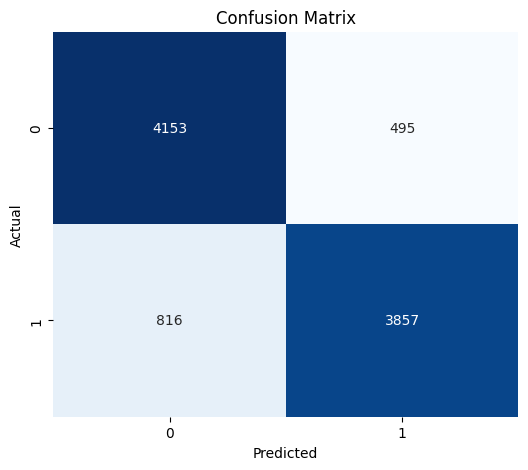

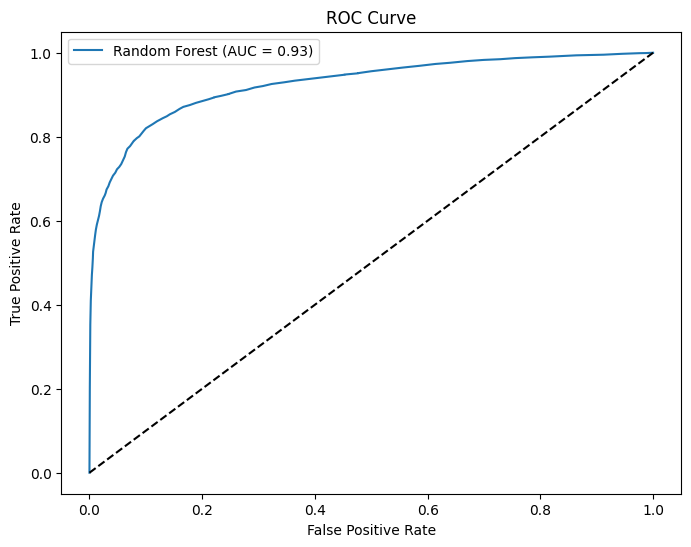

--------------------------------------------------
Training Random Forest on SELECTED Features
--------------------------------------------------
   [Selected Features Results]
   Accuracy:  0.8573
   Precision: 0.8852
   Recall:    0.8220
   F1-Score:  0.8524
   AUC-ROC:   0.9256

5-Fold CV F1-Scores: [0.84451855 0.85009064 0.8415897  0.85159849 0.84135422]
Mean CV F1-Score: 0.8458


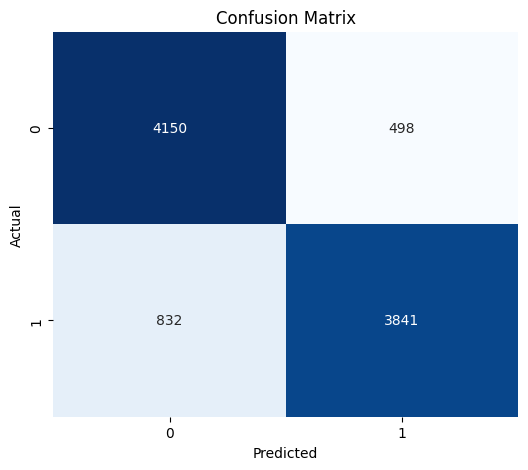

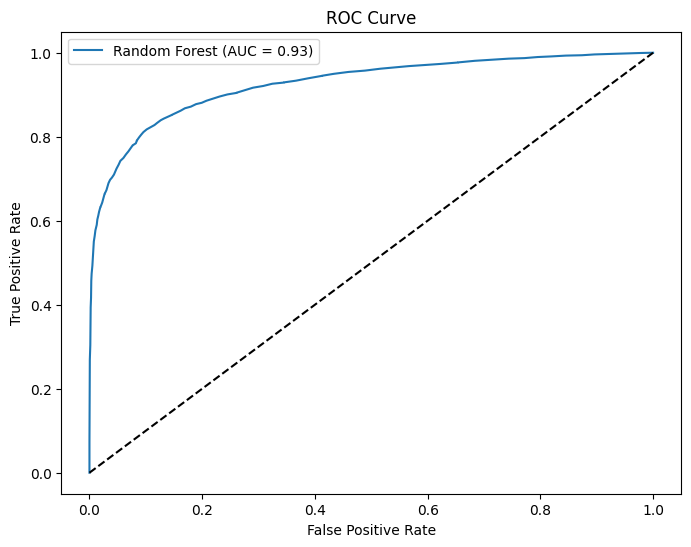

Comparison Summary:
Accuracy Change: -0.0020
F1-Score Change: -0.0023
AUC-ROC Change:  +0.0003


In [21]:
# Part 1: Define the "Regular X" (All Features)
# Ensuring we drop ID, target, and helper columns
X_full = data.drop(['ID', 'default.payment.next.month'], axis=1, errors='ignore')
y = data['default.payment.next.month']

# Split Full Data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Part 2: Use X_selected_Lasso (Features from Lasso)
# Split Selected Data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected_Lasso, y, test_size=0.2, random_state=42)

# Part 3: Train & Evaluate on FULL Features
print("-" * 50)
print("Training Random Forest on ALL Features")
print("-" * 50)
rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train_full, y_train_full)

y_pred_full = rf_full.predict(X_test_full)
y_prob_full = rf_full.predict_proba(X_test_full)[:, 1]

print("   [Full Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test_full, y_pred_full):.4f}")
print(f"   Precision: {precision_score(y_test_full, y_pred_full):.4f}")
print(f"   Recall:    {recall_score(y_test_full, y_pred_full):.4f}")
print(f"   F1-Score:  {f1_score(y_test_full, y_pred_full):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test_full, y_prob_full):.4f}")

# Cross-Validation
cv_scores = cross_val_score(rf_full, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_full, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_full, y_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test_full, y_prob_full):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Part 4: Train & Evaluate on SELECTED Features from Lasso Regression
print("-" * 50)
print("Training Random Forest on SELECTED Features")
print("-" * 50)
rf_sel = RandomForestClassifier(random_state=42)
rf_sel.fit(X_train_sel, y_train_sel)

y_pred_sel = rf_sel.predict(X_test_sel)
y_prob_sel = rf_sel.predict_proba(X_test_sel)[:, 1]

print("   [Selected Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test_sel, y_pred_sel):.4f}")
print(f"   Precision: {precision_score(y_test_sel, y_pred_sel):.4f}")
print(f"   Recall:    {recall_score(y_test_sel, y_pred_sel):.4f}")
print(f"   F1-Score:  {f1_score(y_test_sel, y_pred_sel):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test_sel, y_prob_sel):.4f}")

# Cross-Validation
cv_scores = cross_val_score(rf_sel, X_train_sel, y_train_sel, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_sel, y_pred_sel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_sel, y_prob_sel)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test_sel, y_prob_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Part 5: Quick Comparison
print("Comparison Summary:")
acc_diff = accuracy_score(y_test_sel, y_pred_sel) - accuracy_score(y_test_full, y_pred_full)
f1_diff = f1_score(y_test_sel, y_pred_sel) - f1_score(y_test_full, y_pred_full)
auc_diff = roc_auc_score(y_test_sel, y_prob_sel) - roc_auc_score(y_test_full, y_prob_full)

print(f"Accuracy Change: {acc_diff:+.4f}")
print(f"F1-Score Change: {f1_diff:+.4f}")
print(f"AUC-ROC Change:  {auc_diff:+.4f}")

Classification Method 2: k-NN

--------------------------------------------------
Training kNN on all All Features
--------------------------------------------------
   [Full Features Results]
   Accuracy:  0.7877
   Precision: 0.7901
   Recall:    0.7851
   F1-Score:  0.7876
   AUC-ROC:   0.8618

5-Fold CV F1-Scores: [0.78406652 0.7851752  0.78642607 0.79104678 0.78858835]
Mean CV F1-Score: 0.7871


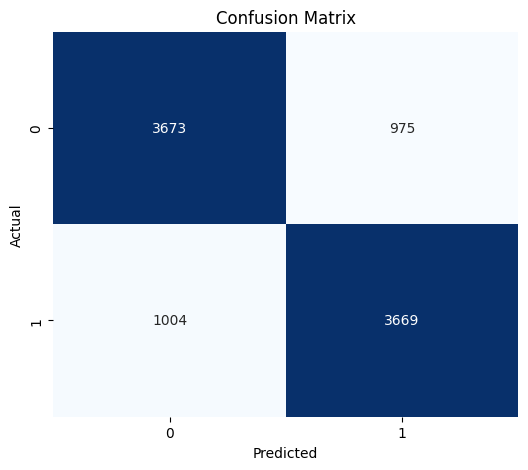

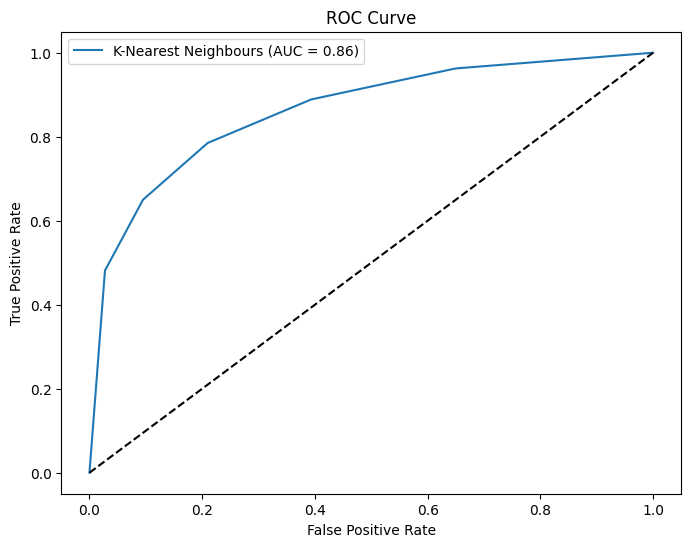

--------------------------------------------------
Training kNN on SELECTED Features
--------------------------------------------------
   [Selected Features Results]
   Accuracy:  0.7741
   Precision: 0.7687
   Recall:    0.7858
   F1-Score:  0.7771
   AUC-ROC:   0.8455

5-Fold CV F1-Scores: [0.76253648 0.76272307 0.76772227 0.77381741 0.76702797]
Mean CV F1-Score: 0.7668


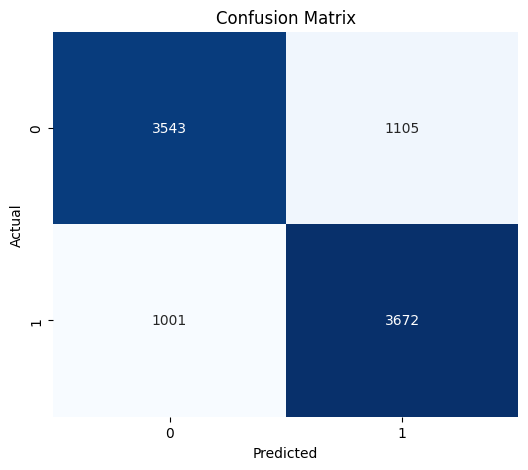

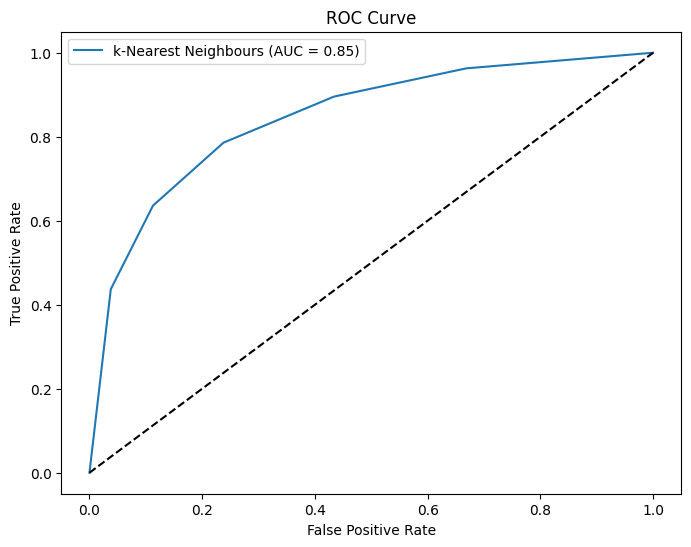

Comparison Summary:
Accuracy Change: -0.0136
F1-Score Change: -0.0104
AUC-ROC Change:  -0.0163


In [29]:
# must run the mutual information cell before running this one.
X = data.drop(['ID', 'default.payment.next.month'], axis=1, errors='ignore')
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected_mi, y, test_size=0.2, random_state=42)

print('-' * 50)
print('Training kNN on all All Features')
print("-" * 50)

knn_full = KNeighborsClassifier()
knn_full.fit(X_train, y_train)

y_pred_full = knn_full.predict(X_test)
y_prob_full = knn_full.predict_proba(X_test)[:, 1]

print("   [Full Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_full):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_full):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_full):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_full):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test, y_prob_full):.4f}")

cv_scores = cross_val_score(knn_full, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'K-Nearest Neighbours (AUC = {roc_auc_score(y_test, y_prob_full):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("-" * 50)
print("Training kNN on SELECTED Features")
print("-" * 50)
knn_sel = KNeighborsClassifier()
knn_sel.fit(X_train_sel, y_train_sel)

y_pred_sel = knn_sel.predict(X_test_sel)
y_prob_sel = knn_sel.predict_proba(X_test_sel)[:, 1]

print("   [Selected Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test_sel, y_pred_sel):.4f}")
print(f"   Precision: {precision_score(y_test_sel, y_pred_sel):.4f}")
print(f"   Recall:    {recall_score(y_test_sel, y_pred_sel):.4f}")
print(f"   F1-Score:  {f1_score(y_test_sel, y_pred_sel):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test_sel, y_prob_sel):.4f}")

# Cross-Validation
cv_scores = cross_val_score(knn_sel, X_train_sel, y_train_sel, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_sel, y_pred_sel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_sel, y_prob_sel)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'k-Nearest Neighbours (AUC = {roc_auc_score(y_test_sel, y_prob_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Part 5: Quick Comparison
print("Comparison Summary:")
acc_diff = accuracy_score(y_test_sel, y_pred_sel) - accuracy_score(y_test, y_pred_full)
f1_diff = f1_score(y_test_sel, y_pred_sel) - f1_score(y_test, y_pred_full)
auc_diff = roc_auc_score(y_test_sel, y_prob_sel) - roc_auc_score(y_test, y_prob_full)

print(f"Accuracy Change: {acc_diff:+.4f}")
print(f"F1-Score Change: {f1_diff:+.4f}")
print(f"AUC-ROC Change:  {auc_diff:+.4f}")

Classification Method 3: SVM (SVC + Linear SVC)


--- Model Evaluation ---
Accuracy: 0.7865
Precision: 0.8590
Recall: 0.6869
F1-Score: 0.7634
AUC-ROC: 0.8565

5-Fold CV F1-Scores: [0.77080552 0.76616766 0.77623939 0.78491456 0.77119525]
Mean CV F1-Score: 0.7739


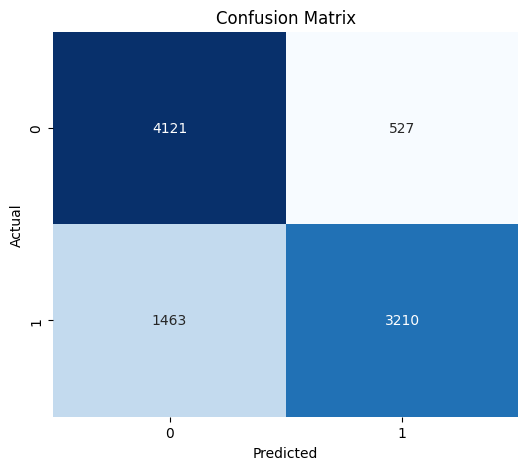

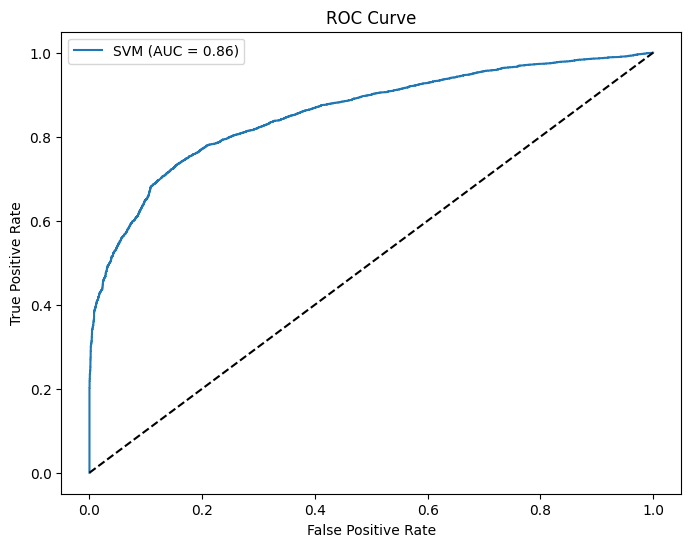


--- Model Evaluation ---
Accuracy: 0.7863
Precision: 0.8593
Recall: 0.6861
F1-Score: 0.7630
AUC-ROC: 0.8676

5-Fold CV F1-Scores: [0.77205991 0.76969063 0.77316198 0.77869822 0.77099464]
Mean CV F1-Score: 0.7729


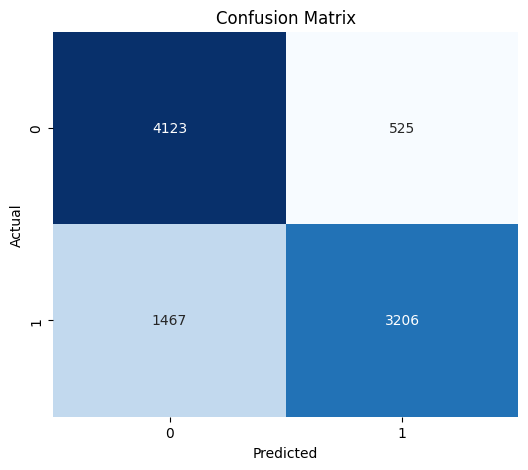

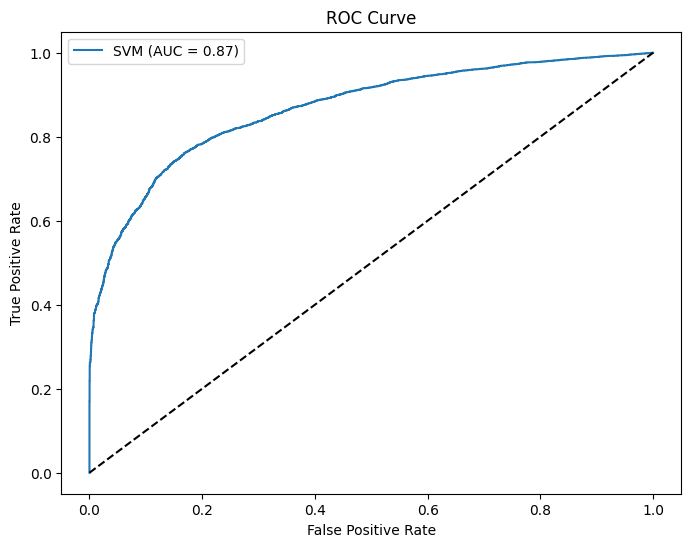

Time Elapsed 1350.5944


In [ ]:
#Use RFE feature selection. From SVM Classifier (Feature Selection vs Regular)\n",
start = time.perf_counter()
y = data['default.payment.next.month']
X_Regular = data.drop(['ID', 'default.payment.next.month'], axis =1 )
X_train, X_test, y_train, y_test = train_test_split(X_selected_RFE, y, test_size=0.2, random_state=42)

svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")


# Cross-Validation",
cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix",
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve\n",
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X_Regular, y, test_size=0.2, random_state=42)

svm_reg = SVC(probability=True, random_state=42)
svm_reg.fit(X_train, y_train)

y_pred = svm_reg.predict(X_test)
y_prob = svm_reg.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")


# Cross-Validation",
cv_scores = cross_val_score(svm_reg, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix",
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve\n",
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

end = time.perf_counter()
time_elapsed = end - start
print(f"Time Elapsed {time_elapsed:.4f}")

LINEAR SVM WITH RFE SELECTED FEATURES

--- Model Evaluation ---
Accuracy: 0.7708
Precision: 0.8267
Recall: 0.6869
F1-Score: 0.7504
AUC-ROC: 0.8444

5-Fold CV F1-Scores: [0.75835777 0.74922601 0.75388027 0.75873202 0.75506608]
Mean CV F1-Score: 0.7551


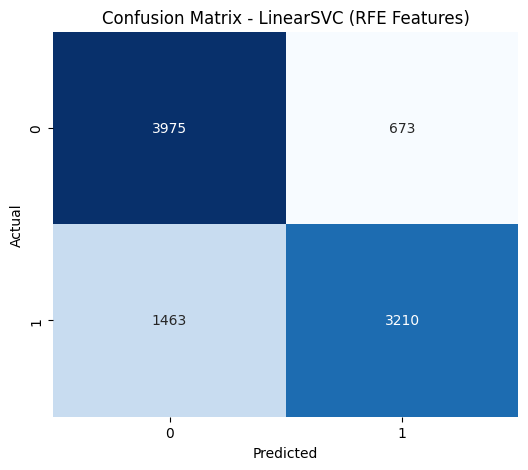

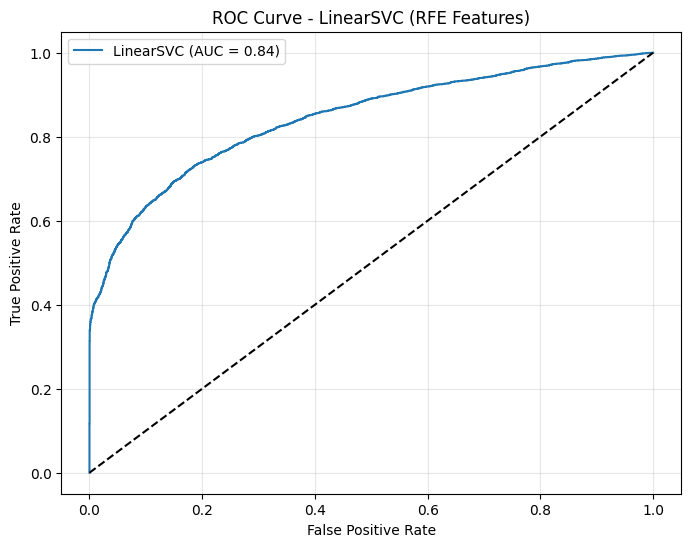

LINEAR SVM WITH ALL FEATURES

--- Model Evaluation ---
Accuracy: 0.7689
Precision: 0.8264
Recall: 0.6824
F1-Score: 0.7475
AUC-ROC: 0.8453

5-Fold CV F1-Scores: [0.75704225 0.74904158 0.75539781 0.76070381 0.75448926]
Mean CV F1-Score: 0.7553


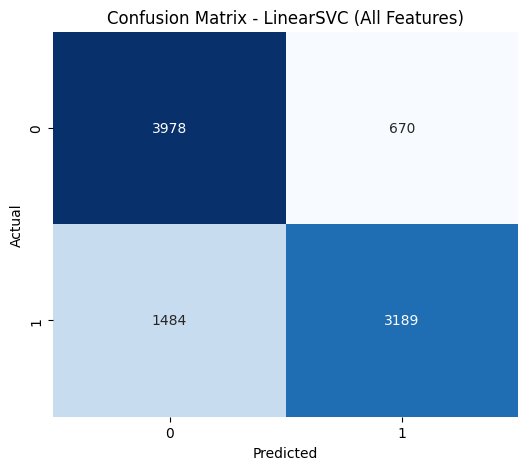

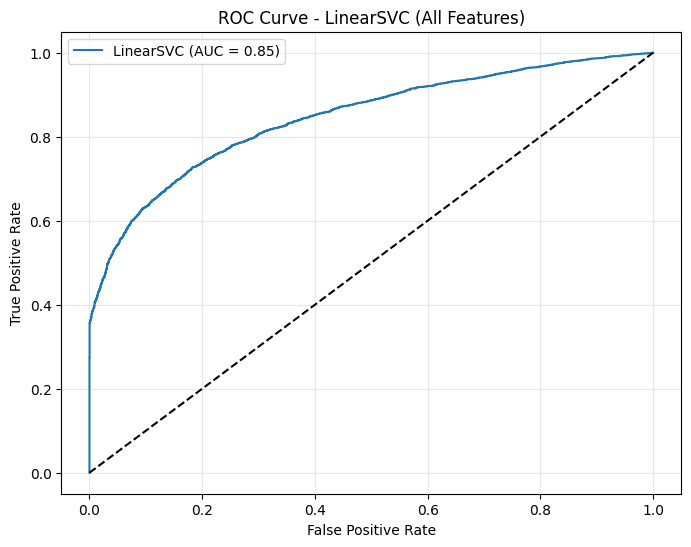

Time Elapsed: 3.0705


In [ ]:
# RFE Feature Selection vs Regular Dataset Comparison with LinearSVC
start = time.perf_counter()
y = data['default.payment.next.month']
X_Regular = data.drop(['ID', 'default.payment.next.month'], axis=1)

# 1. SVM with RFE Selected Features
print("="*60)
print("LINEAR SVM WITH RFE SELECTED FEATURES")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(X_selected_RFE, y, test_size=0.2, random_state=42)

# Create and train LinearSVC
linear_svm = LinearSVC(random_state=42, max_iter=10000)
linear_svm.fit(X_train, y_train)

# Wrap with CalibratedClassifierCV for probability estimates
calibrated_svm = CalibratedClassifierCV(linear_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train, y_train)

# Make predictions
y_pred = calibrated_svm.predict(X_test)
y_prob = calibrated_svm.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

# Cross-Validation
cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LinearSVC (RFE Features)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LinearSVC (RFE Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. SVM with Regular Dataset (All Features)
print("="*60)
print("LINEAR SVM WITH ALL FEATURES")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(X_Regular, y, test_size=0.2, random_state=42)

# Scale features (important for LinearSVC)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train LinearSVC
linear_svm_reg = LinearSVC(random_state=42, max_iter=10000)
linear_svm_reg.fit(X_train_scaled, y_train)

# Wrap with CalibratedClassifierCV for probability estimates
calibrated_svm_reg = CalibratedClassifierCV(linear_svm_reg, method='sigmoid', cv=5)
calibrated_svm_reg.fit(X_train_scaled, y_train)

y_pred = calibrated_svm_reg.predict(X_test_scaled)
y_prob = calibrated_svm_reg.predict_proba(X_test_scaled)[:, 1]

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

# Cross-Validation
cv_scores = cross_val_score(linear_svm_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LinearSVC (All Features)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LinearSVC (All Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

end = time.perf_counter()
time_elapsed = end - start
print(f"Time Elapsed: {time_elapsed:.4f}")

# Hyperparameter Tuning

Grid Search for Classification Method 1: Random Forest

In [ ]:

# --- Step 1: Train Base Model (Before Tuning) ---
print("Training Base Random Forest Model (Default Parameters)...")
# Initialize with default parameters
base_rf = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_selected_Lasso, y, test_size=0.2, random_state=42)
base_rf.fit(X_train, y_train)

# Predict using Base Model
y_pred_base = base_rf.predict(X_test)
y_prob_base = base_rf.predict_proba(X_test)[:, 1]

# Calculate Base Metrics
base_accuracy = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_roc = roc_auc_score(y_test, y_prob_base)

print(f"Base Model Accuracy: {base_accuracy:.4f}")
print(f"Base Model F1-Score: {base_f1:.4f}")
print(f"Base Model AUC-ROC: {base_roc:.4f}")
print("-" * 30)


# --- Step 2: Perform Hyperparameter Tuning (Grid Search) ---
print("Starting Grid Search for Hyperparameter Tuning...")

# Define the parameter grid
# We test different numbers of trees (n_estimators) and depths to find the best balance
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [10, 20, None],          # Max depth of the tree
    'min_samples_split': [2, 5, 10],      # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Min samples required at a leaf node
}

# Initialize GridSearchCV
# cv=5 means 5-fold Cross-Validation
# n_jobs=-1 uses all available CPU cores to speed up processing
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,          # Lowered to 3 for speed, use 5 for final
                           n_jobs=-1,
                           scoring='f1',  # Optimize for F1 Score (good for imbalance)
                           verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")


# --- Step 3: Evaluate Tuned Model ---
print("-" * 30)
print("Evaluating Tuned Random Forest Model...")

# Predict using Tuned Model
y_pred_tuned = best_rf.predict(X_test)
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]

# Calculate Tuned Metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)

print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Tuned Model F1-Score: {tuned_f1:.4f}")
print(f"Tuned Model AUC-ROC: {tuned_roc:.4f}")


# --- Step 4: Comparison & Discussion ---
print("\n" + "="*40)
print("IMPACT OF TUNING (Comparison)")
print("="*40)
print(f"{'Metric':<15} {'Base Model':<15} {'Tuned Model':<15} {'Improvement':<15}")
print(f"{'-'*60}")
print(f"{'Accuracy':<15} {base_accuracy:.4f}           {tuned_accuracy:.4f}           {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'F1-Score':<15} {base_f1:.4f}           {tuned_f1:.4f}           {tuned_f1 - base_f1:+.4f}")
print(f"{'AUC-ROC':<15} {base_roc:.4f}           {tuned_roc:.4f}           {tuned_roc - base_roc:+.4f}")
print("="*40)

Training Base Random Forest Model (Default Parameters)...
Base Model Accuracy: 0.8593
Base Model F1-Score: 0.8547
Base Model AUC-ROC: 0.9254
------------------------------
Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
------------------------------
Evaluating Tuned Random Forest Model...
Tuned Model Accuracy: 0.8599
Tuned Model F1-Score: 0.8554
Tuned Model AUC-ROC: 0.9263

IMPACT OF TUNING (Comparison)
Metric          Base Model      Tuned Model     Improvement    
------------------------------------------------------------
Accuracy        0.8593           0.8599           +0.0005
F1-Score        0.8547           0.8554           +0.0007
AUC-ROC         0.9254           0.9263           +0.0009


Grid/Random Search for Classification Method 2: k-NN

In [ ]:
# --- Step 1: Train Base Model (Before Tuning) ---
print("Training Base k nearest neighbours Model (Default Parameters)...")
base_knn = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(X_selected_mi, y, test_size=0.2, random_state=42)
base_knn.fit(X_train, y_train)

# Predict Base Metrics
y_pred_base = base_knn.predict(X_test)
y_prob_base = base_knn.predict_proba(X_test)[:, 1]

# Calculate Base Metrics
base_accuracy = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_roc = roc_auc_score(y_test, y_prob_base)

print(f"Base Model Accuracy: {base_accuracy:.4f}")
print(f"Base Model F1-Score: {base_f1:.4f}")
print(f"Base Model AUC-ROC: {base_roc:.4f}")
print("-" * 30)

# --- Step 2: Perform Hyperparameter Tuning (Grid Search) ---
print("Starting Grid Search for Hyperparameter Tuning...")

param_grid = {
    'n_neighbors': np.arange(3, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree', 'ball_tree'],
    'leaf_size': np.arange(25, 30)
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            scoring='f1',
                            verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")


# --- Step 3: Evaluate Tuned Model ---
print("-" * 30)
print("Evaluating Tuned k Nearest Neighbours Model...")

# Predict using Tuned Model
y_pred_tuned = best_rf.predict(X_test)
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]

# Calculate Tuned Metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)

print(f"Tuned Model Accuracy: {tuned_accuracy:.4f}")
print(f"Tuned Model F1-Score: {tuned_f1:.4f}")
print(f"Tuned Model AUC-ROC: {tuned_roc:.4f}")


# --- Step 4: Comparison & Discussion ---
print("\n" + "="*40)
print("IMPACT OF TUNING (Comparison)")
print("="*40)
print(f"{'Metric':<15} {'Base Model':<15} {'Tuned Model':<15} {'Improvement':<15}")
print(f"{'-'*60}")
print(f"{'Accuracy':<15} {base_accuracy:.4f}           {tuned_accuracy:.4f}           {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'F1-Score':<15} {base_f1:.4f}           {tuned_f1:.4f}           {tuned_f1 - base_f1:+.4f}")
print(f"{'AUC-ROC':<15} {base_roc:.4f}           {tuned_roc:.4f}           {tuned_roc - base_roc:+.4f}")
print("="*40)

Training Base k nearest neighbours Model (Default Parameters)...
Base Model Accuracy: 0.7601
Base Model F1-Score: 0.7641
Base Model AUC-ROC: 0.8346
------------------------------
Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=distance; total time=   4.5s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=distance; total time=   4.6s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=uniform; total time=   4.6s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=uniform; total time=   4.8s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=distance; total time=   4.7s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=distance; total time=   4.8s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=3, weights=uniform; total time=   4.9s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors

Grid/Random Search for Classification Method 3: SVM (SVC + Linear SVC)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters Found: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

--- Model Evaluation ---
Tuned Model Accuracy: 0.7915
Tuned Model F1-Score: 0.7705
Tuned Model AUC-ROC: 0.8608

IMPACT OF TUNING (Comparison)
Metric          Base Model      Tuned Model     Improvement    
------------------------------------------------------------
Accuracy        0.7865           0.7915           +0.0050
F1-Score        0.7634           0.7705           +0.0071
AUC-ROC         0.8565           0.8608           +0.0042


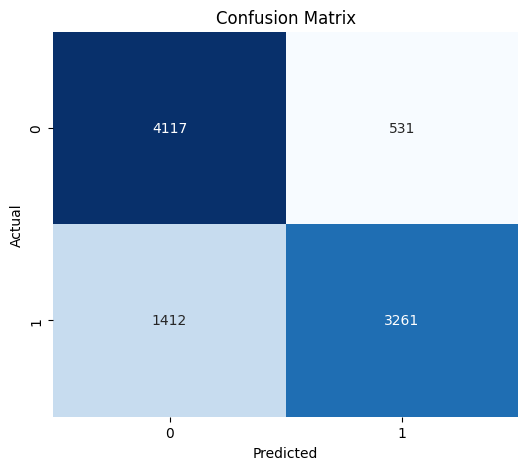

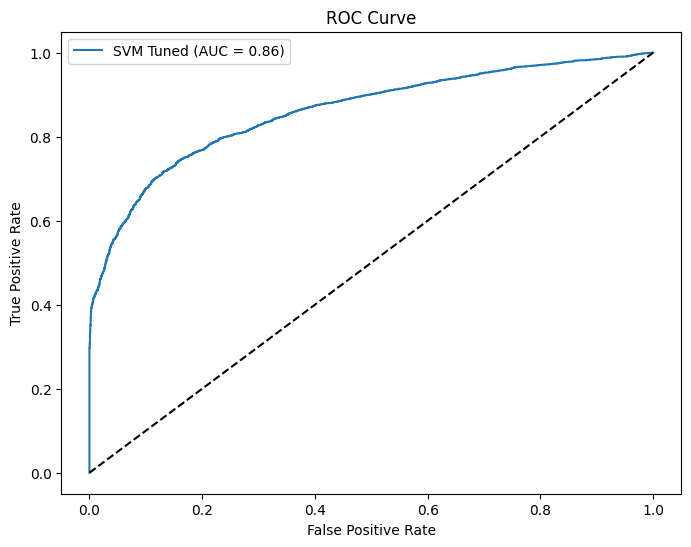

In [ ]:
#Tuning on SVM Non linear
#Hyper Parameters",

X_train, X_test, y_train, y_test = train_test_split(X_selected_RFE, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],                        # Regularization strength,
    'kernel': ['linear', 'rbf','poly'],       # Kernel type,
    'gamma': ['scale', 'auto'],               # Kernel coefficient,
    'degree': [3,4]                           # degree for polynomial,
}

grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation,
    scoring='f1',           # Optimize for F1-score,
    n_jobs=-1,              # Use all available cores,
    verbose=1               # Show progress,
)


grid_search.fit(X_train,y_train)
print(f"Best Parameters Found: {grid_search.best_params_}")
best_grid_model = grid_search.best_estimator_


y_pred_base = svm.predict(X_test)
y_prob_base = svm.predict_proba(X_test)[:, 1]

y_pred = best_grid_model.predict(X_test)
y_prob = best_grid_model.predict_proba(X_test)[:, 1]

base_accuracy = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test,y_pred_base)
base_roc = roc_auc_score(y_test,y_prob_base)

tuned_accuracy = accuracy_score(y_test, y_pred)
tuned_f1 = f1_score(y_test,y_pred)
tuned_roc = roc_auc_score(y_test,y_prob)

print(f"\n--- Model Evaluation ---")

print(f"Tuned Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Tuned Model F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"Tuned Model AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

print("\n" + "="*40)
print("IMPACT OF TUNING (Comparison)")
print("="*40)
print(f"{'Metric':<15} {'Base Model':<15} {'Tuned Model':<15} {'Improvement':<15}")
print(f"{'-'*60}")
print(f"{'Accuracy':<15} {base_accuracy:.4f}           {tuned_accuracy:.4f}           {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'F1-Score':<15} {base_f1:.4f}           {tuned_f1:.4f}           {tuned_f1 - base_f1:+.4f}")
print(f"{'AUC-ROC':<15} {base_roc:.4f}           {tuned_roc:.4f}           {tuned_roc - base_roc:+.4f}")
print("="*40)



# Confusion Matrix",
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve",
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM Tuned (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [ ]:
#Grid Search On linear SVM

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_selected_RFE, y, test_size=0.2, random_state=42)

# 3. Hyperparameter Tuning with Grid Search
print("\n" + "="*60)
print("PERFORMING HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*60)
C_list = []
for i in range(200):
    C_list.append(i * 0.01 + 0.01)

param_grid = [
    {
        'C': C_list,
        'loss': ['hinge'],
        'penalty': ['l2'],  # hinge only works with l2
        'dual': [True]      # hinge + l2 requires dual=True
    },
    {
        'C': C_list,
        'loss': ['squared_hinge'],
        'penalty': ['l1', 'l2'],
        'dual': [False]    # squared_hinge works with both l1 and l2, use primal
    }
]

grid_search = GridSearchCV(
    estimator=LinearSVC(random_state=42, max_iter=10000),
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='f1',           # Optimize for F1-score
    n_jobs=-1,              # Use all available cores
    verbose=1               # Show progress
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print(f"Best Parameters Found: {grid_search.best_params_}")
best_grid_model = grid_search.best_estimator_

# Wrap best model with CalibratedClassifierCV for probability estimates
calibrated_best = CalibratedClassifierCV(best_grid_model, method='sigmoid', cv=5)
calibrated_best.fit(X_train, y_train)

# 4. Predictions
y_pred_base = calibrated_svm.predict(X_test)
y_prob_base = calibrated_svm.predict_proba(X_test)[:, 1]

y_pred_tuned = calibrated_best.predict(X_test)
y_prob_tuned = calibrated_best.predict_proba(X_test)[:, 1]

# 5. Calculate Metrics
base_accuracy = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_roc = roc_auc_score(y_test, y_prob_base)

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)

# 6. Print Results
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

print(f"\n--- Baseline Model (Default Parameters) ---")
print(f"Accuracy:  {base_accuracy:.4f}")
print(f"F1-Score:  {base_f1:.4f}")
print(f"AUC-ROC:   {base_roc:.4f}")

print(f"\n--- Tuned Model (Grid Search Best Parameters) ---")

print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"AUC-ROC:   {tuned_roc:.4f}")

print("\n" + "="*60)
print("IMPACT OF HYPERPARAMETER TUNING")
print("="*60)
print(f"{'Metric':<12} {'Base Model':<12} {'Tuned Model':<12} {'Improvement':<12}")
print(f"{'-'*48}")
print(f"{'Accuracy':<12} {base_accuracy:.4f}       {tuned_accuracy:.4f}       {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'F1-Score':<12} {base_f1:.4f}       {tuned_f1:.4f}       {tuned_f1 - base_f1:+.4f}")
print(f"{'AUC-ROC':<12} {base_roc:.4f}       {tuned_roc:.4f}       {tuned_roc - base_roc:+.4f}")
print("="*60)


PERFORMING HYPERPARAMETER TUNING WITH GRID SEARCH
Starting Grid Search...
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Best Parameters Found: {'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

MODEL EVALUATION RESULTS

--- Baseline Model (Default Parameters) ---
Accuracy:  0.7708
F1-Score:  0.7504
AUC-ROC:   0.8444

--- Tuned Model (Grid Search Best Parameters) ---
Accuracy:  0.7708
F1-Score:  0.7504
AUC-ROC:   0.8444

IMPACT OF HYPERPARAMETER TUNING
Metric       Base Model   Tuned Model  Improvement 
------------------------------------------------
Accuracy     0.7708       0.7708       +0.0000
F1-Score     0.7504       0.7504       +0.0000
AUC-ROC      0.8444       0.8444       +0.0000
